In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0354

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - loss: 0.0252
Average validation loss: 0.6402711868286133
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - loss: 0.0252 - val_loss: 0.6403
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - loss: 0.0156 - val_loss: 0.6403
Average validation loss: 0.5728559494018555
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - loss: 0.0156 - val_loss: 0.6066
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - loss: 0.0112 - val_loss: 0.6066
Average validation loss: 0.4914257526397705
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 545ms/step - loss: 0.0112 - val_loss: 0.5682
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 798ms/step - loss: 3.0077e-07
Average validation loss: 0.051868341863155365
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 812ms/step - loss: 3.0077e-07 - val_loss: 0.0519
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 834ms/step - loss: 2.9052e-07 - val_loss: 0.0519
Average validation loss: 0.05467063747346401
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 844ms/step - loss: 2.9052e-07 - val_loss: 0.0533
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 791ms/step - loss: 2.8654e-07 - val_loss: 0.0533
Average validation loss: 0.06821762397885323
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 805ms/step - loss: 2.8654e-07 - val_loss: 0.0583
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 818ms/step - loss: 2.8007e-07 - val_loss: 0.0583
Average validation loss: 0.06266973353922367
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 830ms/step - loss: 2.8007e-07 - val_loss: 0.0594
Epoch 5/10
8/8 ━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 831ms/step - loss: 8.4626e-08
Average validation loss: 0.03392089499781529
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 840ms/step - loss: 8.4626e-08 - val_loss: 0.0339
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 831ms/step - loss: 7.9662e-08 - val_loss: 0.0339
Average validation loss: 0.033962275522450604
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 843ms/step - loss: 7.9662e-08 - val_loss: 0.0339
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 864ms/step - loss: 7.6079e-08 - val_loss: 0.0339
Average validation loss: 0.03382709715515375
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 876ms/step - loss: 7.6079e-08 - val_loss: 0.0339
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 941ms/step - loss: 7.3998

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 760ms/step - loss: 6.6124e-08
Average validation loss: 0.03910724027082324
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 773ms/step - loss: 6.6124e-08 - val_loss: 0.0391
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 766ms/step - loss: 6.5394e-08 - val_loss: 0.0391
Average validation loss: 0.034267837181687355
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 779ms/step - loss: 6.5394e-08 - val_loss: 0.0367
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 767ms/step - loss: 6.3290e-08 - val_loss: 0.0367
Average validation loss: 0.03707593400031328
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 780ms/step - loss: 6.3290e-08 - val_loss: 0.0368
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 780ms/step - loss: 6.3658

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 788ms/step - loss: 6.5709e-08
Average validation loss: 0.023562469705939292
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 797ms/step - loss: 6.5709e-08 - val_loss: 0.0236
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 772ms/step - loss: 5.6774e-08 - val_loss: 0.0236
Average validation loss: 0.02726480597630143
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 781ms/step - loss: 5.6774e-08 - val_loss: 0.0254
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 786ms/step - loss: 5.2420e-08 - val_loss: 0.0254
Average validation loss: 0.024281146377325057
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 797ms/step - loss: 5.2420e-08 - val_loss: 0.0250
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 788ms/step - loss: 4.8493e-08 - val_loss: 0.0250
Average validation loss: 0.03384385369718075
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 798ms/step - loss: 4.8493e-08 - val_loss: 0.0272
Epoch 5

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 797ms/step - loss: 1.0036e-07
Average validation loss: 0.020722208078950644
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 806ms/step - loss: 1.0036e-07 - val_loss: 0.0207
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 773ms/step - loss: 8.3476e-08 - val_loss: 0.0207
Average validation loss: 0.021394627712046105
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 783ms/step - loss: 8.3476e-08 - val_loss: 0.0211
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 772ms/step - loss: 7.1745e-08 - val_loss: 0.0211
Average validation loss: 0.022830376867204905
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 782ms/step - loss: 7.1745e-08 - val_loss: 0.0216
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 781ms/step - loss: 6.7326e-08 - val_loss: 0.0216
Average validation loss: 0.025835205956051748
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 790ms/step - loss: 6.7326e-08 - val_loss: 0.0227
Epoch

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 773ms/step - loss: 6.6431e-08
Average validation loss: 0.047037286777049304
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 783ms/step - loss: 6.6431e-08 - val_loss: 0.0470
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 764ms/step - loss: 6.5447e-08 - val_loss: 0.0470
Average validation loss: 0.05103795425966382
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 774ms/step - loss: 6.5447e-08 - val_loss: 0.0490
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 774ms/step - loss: 5.9792e-08 - val_loss: 0.0490
Average validation loss: 0.0422250684350729
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 785ms/step - loss: 5.9792e-08 - val_loss: 0.0468
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 124s 763ms/step - loss: 5.6293

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 777ms/step - loss: 2.9911e-07
Average validation loss: 0.031919174361974
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 2.9911e-07 - val_loss: 0.0319
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 785ms/step - loss: 2.7267e-07 - val_loss: 0.0319
Average validation loss: 0.020372073088462155
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 797ms/step - loss: 2.7267e-07 - val_loss: 0.0261
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 115s 814ms/step - loss: 2.5840e-07 - val_loss: 0.0261
Average validation loss: 0.02016012246410052
48/48 ━━━━━━━━━━━━━━━━━━━━ 116s 827ms/step - loss: 2.5840e-07 - val_loss: 0.0242
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 773ms/step - loss: 1.1277e-07
Average validation loss: 0.1296990199812821
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 785ms/step - loss: 1.1277e-07 - val_loss: 0.1297
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 783ms/step - loss: 1.4002e-07 - val_loss: 0.1297
Average validation loss: 0.022295369267729775
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 795ms/step - loss: 1.4002e-07 - val_loss: 0.0760
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 133s 793ms/step - loss: 1.4870e-07 - val_loss: 0.0760
Average validation loss: 0.023539795307442546
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 804ms/step - loss: 1.4870e-07 - val_loss: 0.0585
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 179s 798ms/step - loss: 1.4

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 825ms/step - loss: 5.0328e-08
Average validation loss: 0.014957837760448456
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 837ms/step - loss: 5.0328e-08 - val_loss: 0.0150
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 774ms/step - loss: 4.6371e-08 - val_loss: 0.0150
Average validation loss: 0.01426719140727073
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 785ms/step - loss: 4.6371e-08 - val_loss: 0.0146
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 775ms/step - loss: 4.3186e-08 - val_loss: 0.0146
Average validation loss: 0.016130309464642778
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 787ms/step - loss: 4.3186e-08 - val_loss: 0.0151
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 204s 776ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 780ms/step - loss: 1.7713e-07
Average validation loss: 0.02822585623814828
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 792ms/step - loss: 1.7713e-07 - val_loss: 0.0282
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 777ms/step - loss: 1.7670e-07 - val_loss: 0.0282
Average validation loss: 0.03067482780251238
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 787ms/step - loss: 1.7670e-07 - val_loss: 0.0295
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 776ms/step - loss: 1.6900e-07 - val_loss: 0.0295
Average validation loss: 0.025936783912281196
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 787ms/step - loss: 1.6900e-07 - val_loss: 0.0283
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 774ms/step - loss: 1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 777ms/step - loss: 4.8148e-08
Average validation loss: 0.01721812696196139
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 788ms/step - loss: 4.8148e-08 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 780ms/step - loss: 4.8168e-08 - val_loss: 0.0172
Average validation loss: 0.024776252638548612
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 791ms/step - loss: 4.8168e-08 - val_loss: 0.0210
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 189s 780ms/step - loss: 4.6622e-08 - val_loss: 0.0210
Average validation loss: 0.015782316611148418
80/80 ━━━━━━━━━━━━━━━━━━━━ 190s 791ms/step - loss: 4.6622e-08 - val_loss: 0.0193
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_100.pth'.
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 252s 782ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 779ms/step - loss: 2.7087e-07
Average validation loss: 0.02870832389453426
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 790ms/step - loss: 2.7087e-07 - val_loss: 0.0287
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 774ms/step - loss: 2.2240e-07 - val_loss: 0.0287
Average validation loss: 0.02697711092575143
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 785ms/step - loss: 2.2240e-07 - val_loss: 0.0278
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 775ms/step - loss: 2.0687e-07 - val_loss: 0.0278
Average validation loss: 0.03421518544200808
96/96 ━━━━━━━━━━━━━━━━━━━━ 227s 787ms/step - loss: 2.0687e-07 - val_loss: 0.0300
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 300s 767ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 780ms/step - loss: 3.1334e-06
Average validation loss: 0.027264696270382652
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 791ms/step - loss: 3.1334e-06 - val_loss: 0.0273
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 778ms/step - loss: 1.7653e-06 - val_loss: 0.0273
Average validation loss: 0.019999323080992327
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 789ms/step - loss: 1.7653e-06 - val_loss: 0.0236
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 777ms/step - loss: 1.2814e-06 - val_loss: 0.0236
Average validation loss: 0.025477316631683303
120/120 ━━━━━━━━━━━━━━━━━━━━ 284s 788ms/step - loss: 1.2814e-06 - val_loss: 0.0242
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 377s 77

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 781ms/step - loss: 8.2642e-08
Average validation loss: 0.021326596922638903
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 792ms/step - loss: 8.2642e-08 - val_loss: 0.0213
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 775ms/step - loss: 7.1879e-08 - val_loss: 0.0213
Average validation loss: 0.019121015499371827
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 786ms/step - loss: 7.1879e-08 - val_loss: 0.0202
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 339s 775ms/step - loss: 6.5733e-08 - val_loss: 0.0202
Average validation loss: 0.028302361246547194
144/144 ━━━━━━━━━━━━━━━━━━━━ 340s 785ms/step - loss: 6.5733e-08 - val_loss: 0.0229
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 452s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 782ms/step - loss: 6.3646e-08
Average validation loss: 0.01798475117975613
160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 793ms/step - loss: 6.3646e-08 - val_loss: 0.0180
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 253s 789ms/step - loss: 5.0739e-08 - val_loss: 0.0180
Average validation loss: 0.016621488743476222
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 800ms/step - loss: 5.0739e-08 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 787ms/step - loss: 5.4914e-08 - val_loss: 0.0173
Average validation loss: 0.022334102097374853
160/160 ━━━━━━━━━━━━━━━━━━━━ 383s 797ms/step - loss: 5.4914e-08 - val_loss: 0.0190
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 511s 8

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 771ms/step - loss: 3.1710e-08
Average validation loss: 0.02437205604758674
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 782ms/step - loss: 3.1710e-08 - val_loss: 0.0244
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 311s 773ms/step - loss: 2.8193e-08 - val_loss: 0.0244
Average validation loss: 0.01720186806975107
200/200 ━━━━━━━━━━━━━━━━━━━━ 313s 784ms/step - loss: 2.8193e-08 - val_loss: 0.0208
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 469s 776ms/step - loss: 2.5968e-08 - val_loss: 0.0208
Average validation loss: 0.04881148626095637
200/200 ━━━━━━━━━━━━━━━━━━━━ 471s 787ms/step - loss: 2.5968e-08 - val_loss: 0.0301
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 627s 780

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 779ms/step - loss: 8.4454e-08
Average validation loss: 0.05261880448001263
240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 790ms/step - loss: 8.4454e-08 - val_loss: 0.0526
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 375s 772ms/step - loss: 7.1040e-08 - val_loss: 0.0526
Average validation loss: 0.05207662389731347
240/240 ━━━━━━━━━━━━━━━━━━━━ 378s 783ms/step - loss: 7.1040e-08 - val_loss: 0.0523
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 563s 773ms/step - loss: 6.5711e-08 - val_loss: 0.0523
Average validation loss: 0.04856774478611901
240/240 ━━━━━━━━━━━━━━━━━━━━ 566s 784ms/step - loss: 6.5711e-08 - val_loss: 0.0511
Saved model weights to 'c:\天_11157065\git\Ripple

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1211158374324441, 0.0481283223349601, 0.030048313092750804, 0.034382710382342335, 0.02837890281714499, 0.022280928258163236, 0.04192685517575592, 0.025446051346759, 0.02760590571710574, 0.06664569771033711, 0.02846645147332715, 0.02211907904478722, 0.026624591858126222, 0.029641810713852045, 0.03740228404658069, 0.03343394028931285, 0.055321398475129395, 0.20524586914488296]
std_val_losses =  [0.13520504396742505, 0.01951561788701117, 0.010641977137934322, 0.007096948954387855, 0.008427499779934284, 0.005390677565978936, 0.017661342190652345, 0.005732081922694567, 0.01934832102121874, 0.058679333786558784, 0.010720155794638676, 0.006443807401387805, 0.009538413942119815, 0.015249289114527621, 0.024093457918539958, 0.02304108129852428, 0.04297133065783562, 0.14089872015846297]


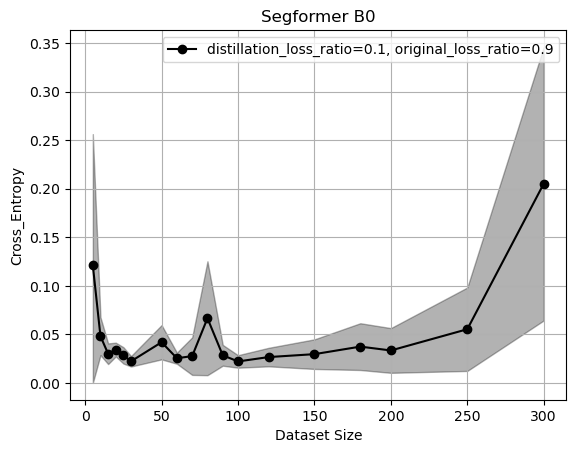

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()